In [1]:
!pip install TensorFlow

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

In [64]:
train = pd.read_csv("train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [65]:
train.loc[:,"Lastname"] = train.Name.str.split(",").apply(lambda l: l[0])
train.groupby(["Lastname","Ticket"]).Fare.std().fillna(0).max()

0.0

In [66]:
price_map = train.groupby(["Lastname","Ticket"]).Fare.min() / train.groupby(["Lastname","Ticket"]).size()
family_size_map = train.groupby(["Lastname","Ticket"]).size()
train = train.set_index(["Lastname","Ticket"], drop = True)
train.loc[:,"Price"] = train.index.map(price_map)
train.loc[:,"Family_size"] = train.index.map(family_size_map)
train = train.reset_index()

In [67]:
train = pd.get_dummies(train, columns=["Pclass", "Embarked", "Sex"])

In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Lastname     891 non-null    object 
 1   Ticket       891 non-null    object 
 2   PassengerId  891 non-null    int64  
 3   Survived     891 non-null    int64  
 4   Name         891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Price        891 non-null    float64
 11  Family_size  891 non-null    int64  
 12  Pclass_1     891 non-null    uint8  
 13  Pclass_2     891 non-null    uint8  
 14  Pclass_3     891 non-null    uint8  
 15  Embarked_C   891 non-null    uint8  
 16  Embarked_Q   891 non-null    uint8  
 17  Embarked_S   891 non-null    uint8  
 18  Sex_female   891 non-null    uint8  
 19  Sex_male

In [69]:
train.Age = train.Age.fillna(train.Age.median())

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

<AxesSubplot:xlabel='Price', ylabel='Density'>

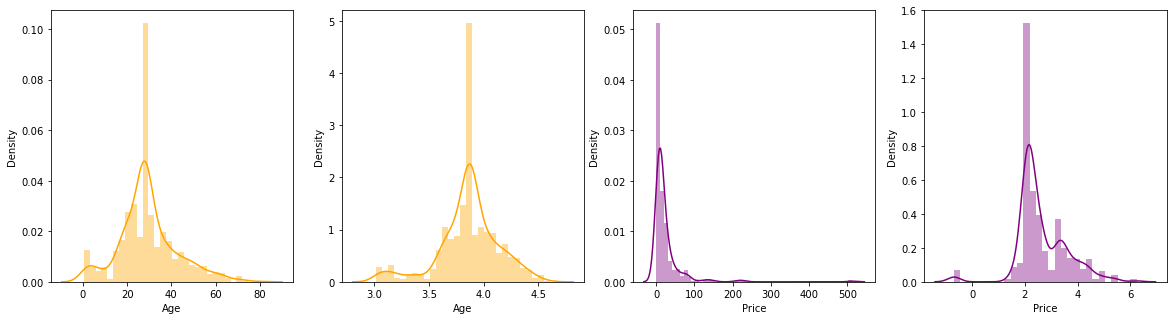

In [70]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
sns.distplot(train.Age, ax=ax[0], color="Orange")
sns.distplot(train.Age.apply(lambda l: np.log(l+20)), ax=ax[1], color="Orange")
sns.distplot(train.Price, ax=ax[2], color="Purple")
sns.distplot(train.Price.apply(lambda l: np.log(l+0.5)), ax=ax[3], color="Purple")

In [71]:
train.Age = train.Age.apply(lambda l: np.log(l+20))
train.Price = train.Price.apply(lambda l: np.log(l+0.5))

In [72]:
to_drop = ["PassengerId", "Ticket", "Lastname", "Sex_male", "Name", "SibSp", "Parch", "Cabin", "Fare"]
train = train.drop(to_drop, axis=1)
train.head()

,Survived,Age,Price,Family_size,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female
0,0,3.737670,2.047693,1,0,0,1,0,0,1,0
1,1,4.060443,4.273652,1,1,0,0,1,0,0,1
2,1,3.828641,2.131203,1,0,0,1,0,0,1,1
3,1,4.007333,3.297687,2,1,0,0,0,0,1,1
4,0,4.007333,2.145931,1,0,0,1,0,0,1,0


In [73]:
X_train = train.drop(["Survived"],axis = 1)

In [74]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
def create_model(lyrs=[8], act='linear', opt='Adam', dr=0.0):
    
    model = Sequential()
    
    # create first hidden layer
    model.add(Dense(lyrs[0], input_dim=X_train.shape[1], activation=act))
    
    # create additional hidden layers
    for i in range(1,len(lyrs)):
        model.add(Dense(lyrs[i], activation=act))
        
    # add dropout, default is none
    model.add(Dropout(dr))
    
    # create output layer
    model.add(Dense(1, activation='sigmoid'))  # output layer
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [75]:
model = create_model()
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 8)                 88        
_________________________________________________________________
dropout_6 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 9         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
None


In [76]:
X = train[['Age','Price','Family_size','Pclass_1','Pclass_2','Pclass_3','Embarked_C','Embarked_Q','Embarked_S','Sex_female']]
y = train[['Survived']]
training = model.fit(X, y, epochs=150, batch_size=32, validation_split=0.25, verbose=0)
val_acc = np.mean(training.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))


val_acc: 81.31%


In [93]:
X.shape

(891, 10)

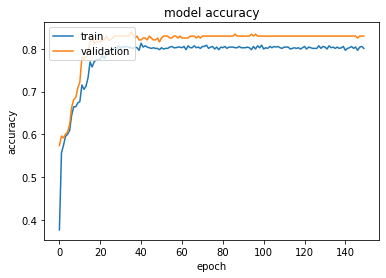

In [77]:
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [143]:
test = pd.read_csv("test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [144]:
test.loc[:,"Lastname"] = test.Name.str.split(",").apply(lambda l: l[0])
test.groupby(["Lastname","Ticket"]).Fare.std().fillna(0).max()

0.0

In [145]:
price_map = test.groupby(["Lastname","Ticket"]).Fare.min() / test.groupby(["Lastname","Ticket"]).size()
family_size_map = test.groupby(["Lastname","Ticket"]).size()
test = test.set_index(["Lastname","Ticket"], drop = True)
test.loc[:,"Price"] = test.index.map(price_map)
test.loc[:,"Family_size"] = test.index.map(family_size_map)
test = test.reset_index()

In [146]:
test = pd.get_dummies(test, columns=["Pclass", "Embarked", "Sex"])

In [147]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Lastname     418 non-null    object 
 1   Ticket       418 non-null    object 
 2   PassengerId  418 non-null    int64  
 3   Name         418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Fare         417 non-null    float64
 8   Cabin        91 non-null     object 
 9   Price        417 non-null    float64
 10  Family_size  418 non-null    int64  
 11  Pclass_1     418 non-null    uint8  
 12  Pclass_2     418 non-null    uint8  
 13  Pclass_3     418 non-null    uint8  
 14  Embarked_C   418 non-null    uint8  
 15  Embarked_Q   418 non-null    uint8  
 16  Embarked_S   418 non-null    uint8  
 17  Sex_female   418 non-null    uint8  
 18  Sex_male     418 non-null    uint8  
dtypes: float

In [148]:
test.Age = test.Age.fillna(train.Age.median())

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

<AxesSubplot:xlabel='Price', ylabel='Density'>

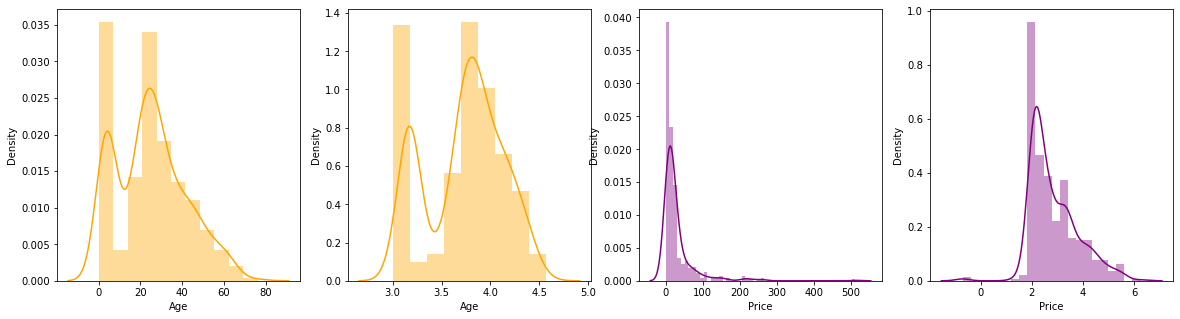

In [149]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
sns.distplot(test.Age, ax=ax[0], color="Orange")
sns.distplot(test.Age.apply(lambda l: np.log(l+20)), ax=ax[1], color="Orange")
sns.distplot(test.Price, ax=ax[2], color="Purple")
sns.distplot(test.Price.apply(lambda l: np.log(l+0.5)), ax=ax[3], color="Purple")

In [150]:
test.Age = train.Age.apply(lambda l: np.log(l+20))
test.Price = train.Price.apply(lambda l: np.log(l+0.5))

In [151]:
to_drop = ["PassengerId", "Ticket", "Lastname", "Sex_male", "Name", "SibSp", "Parch", "Cabin", "Fare"]
X_test = test.drop(to_drop, axis=1)
X_test.head()

,Age,Price,Family_size,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female
0,3.167063,0.935188,1,0,0,1,0,1,0,0
1,3.180569,1.563112,1,0,0,1,0,0,1,1
2,3.170888,0.967441,1,0,1,0,0,1,0,0
3,3.178359,1.334392,1,0,0,1,0,0,1,0
4,3.178359,0.973023,1,0,0,1,0,0,1,1


In [152]:
test['Survived'] = model.predict(X_test)

In [153]:
test.Survived = test.Survived.fillna(0)
test['Survived'] = test['Survived'].apply(lambda x: round(x,0)).astype('int')

In [156]:
Solution = test[['PassengerId','Survived']]

In [157]:
Solution

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [158]:
Solution.to_csv("submission.csv", index=False)